In [75]:

#%matplotlib inline 

###########
#PDF PROCESSING FOR various INPUT 
# DEPENDING ON THE PDF_PROCESSING CLASS
#by Carl Schleussner, Climate Analytics
#carl.schleussner@climateanalytics.org
###########

# IMPORT AND CONFIG 
import numpy as np
import netCDF4 as net
import dimarray as da 
import sys,glob,datetime,pickle,os,itertools
import pandas as pd
import matplotlib.pylab as plt 
from netCDF4 import Dataset,netcdftime,num2date
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon, MultiPolygon


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8,6
from matplotlib import rc
rc('text', usetex=True)

os.chdir('/Users/peterpfleiderer/Documents/Projects/0p5_observed/pdf_processing/')
try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")

###########
# Settings
###########

# PDF Method (currently defined: hist, python_silverman)
pdf_method='python_silverman'

# variables
varin_dict={
    'TXx':{'var_name':'TXX','longname':'Hot extremes (TXx)','unit':'TXx [$^\circ$ C]'}}

# time informations and periods
timeaxis=np.arange(1958,2011)
ref_period=[1960,1979]
target_periods=[[1991,2010],ref_period]
period_names=['Recent','ref']

# Set range for years for bootstrap sampling 
bs_range=[1958,2010]

# Input datasets
datasets=['HadEX2','GHCNDEX']

varoutdict={
    datasets[0]:{},    
    datasets[1]:{},    
}

# Set plottint colours
colordict={
    datasets[0]:"#247a9c",
    datasets[1]:"#df1a20",
}

In [76]:
##############
# HadEx2 & GHCND
##############

for varin in varin_dict.keys():
    for dataset in ['HadEX2','GHCNDEX']:
        print varin,dataset
        if dataset =='HadEX2':
            read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/HadEx2/H2_'+varin_dict[varin]['var_name']+'_1901-2010_RegularGrid_global_3.75x2.5deg_LSmask.nc')['Ann']
        elif dataset =='GHCNDEX':
            read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/GHCND/GHCND_'+varin_dict[varin]['var_name']+'_1951-2016_RegularGrid_global_2.5x2.5deg_LSmask.nc')['Ann']
        
        # Set regular integer time axis, dimarray default always adds month and day. Time range 1958-2010
        input_data=da.DimArray(read_in_data[19580101:20100101,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['year', 'lat', 'lon'] )
        
        # mask Greenland
        landmask=input_data.ix[10,:,:].copy()
        landmask[:,:]=1
        if dataset =='HadEX2': 
            GRL_mask=Dataset('support/GRL_73x96_lat_weighted.nc4').variables['GRL'][:,:]
        if dataset == 'GHCNDEX':
            GRL_mask=Dataset('support/GRL_73x144_lat_weighted.nc4').variables['GRL'][:,:]
        landmask[np.isfinite(GRL_mask)]=0 
            
        # Mask for data availability (individual for each dataset)
        varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
        varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods,landmask=landmask,required_coverage=0.8,dataset=dataset)


TXx HadEX2
TXx GHCNDEX


In [77]:
##############
# Regional Masking
##############

for varin in varin_dict.keys():
    for dataset in ['HadEX2','GHCNDEX']:
        varoutdict[dataset][varin].derive_regional_masking(shift_lon=-180.0,region_polygons=region_polygons,region_type='EU_NA_AS_RU_AU',dataset=dataset,overwrite=True)


Europe
Australia
North_America
Asia
Russia
Europe
Australia
North_America
Asia
Russia


In [78]:
###############
# get PDFs and bootstrap
###############

cut_interval_dict={
    'TXx':[-2,3]}

for varin in varin_dict.keys():
    print '\n-------------------',varin    
    for dataset in ['HadEX2','GHCNDEX']:
        print dataset
        # relative diff for precipitation indices
        if varin in ['RX5','RX1']:relative_diff=True
        if varin not in ['RX5','RX1']:relative_diff=False
            
        varoutdict[dataset][varin].derive_time_slices(ref_period,target_periods,period_names)
        varoutdict[dataset][varin].derive_distributions()
            
        varoutdict[dataset][varin].derive_pdf_difference('ref','Recent',pdf_method=pdf_method,bin_range=cut_interval_dict[varin],relative_diff=relative_diff)

        # Get bootstrapping confidence intervals
        varoutdict[dataset][varin].bootstrapping(bs_range,10)   
        varoutdict[dataset][varin].derive_bootstrapped_conf_interval(pdf_method=pdf_method,relative_diff=relative_diff)
        print '...........................'


------------------- TXx
HadEX2
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0


pdf_processing.py:423: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1094 but corresponding boolean dimension is 94
  kde=gaussian_kde(diff[diff_nan_filter][inside_cutinterval],weights=weights[diff_nan_filter][inside_cutinterval])
pdf_processing.py:423: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1094 but corresponding boolean dimension is 43
  kde=gaussian_kde(diff[diff_nan_filter][inside_cutinterval],weights=weights[diff_nan_filter][inside_cutinterval])
pdf_processing.py:423: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1094 but corresponding boolean dimension is 257
  kde=gaussian_kde(diff[diff_nan_filter][inside_cutinterval],weights=weights[diff_nan_filter][inside_cutinterval])
pdf_processing.py:423: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1094 but correspo

Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
...........................
GHCNDEX
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, NaNs in difference kernel estimation. No of NaNs: 0


pdf_processing.py:423: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1434 but corresponding boolean dimension is 136
  kde=gaussian_kde(diff[diff_nan_filter][inside_cutinterval],weights=weights[diff_nan_filter][inside_cutinterval])
pdf_processing.py:423: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1434 but corresponding boolean dimension is 97
  kde=gaussian_kde(diff[diff_nan_filter][inside_cutinterval],weights=weights[diff_nan_filter][inside_cutinterval])
pdf_processing.py:423: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1434 but corresponding boolean dimension is 318
  kde=gaussian_kde(diff[diff_nan_filter][inside_cutinterval],weights=weights[diff_nan_filter][inside_cutinterval])
pdf_processing.py:423: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1434 but corresp

Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
...........................


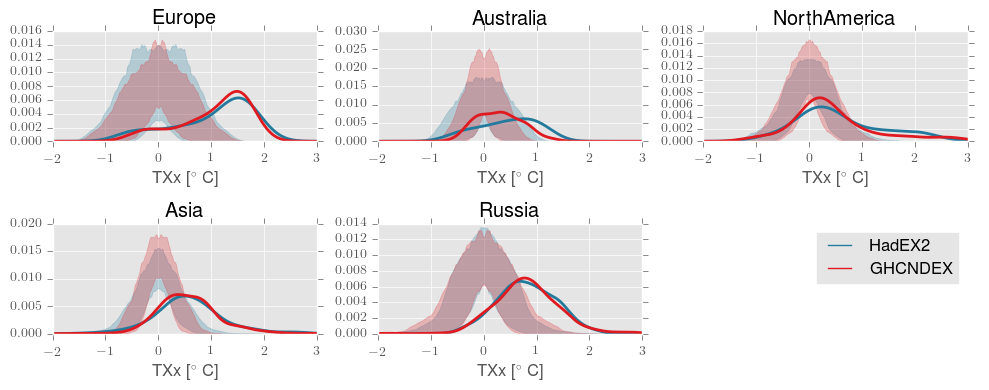

In [81]:
###########
# Plot Main
###########
f,pl=plt.subplots(nrows=2,ncols=3,figsize=(10,4))
pplot=pl.flatten()

varin='TXx'
distro='pdf'



for region,k in zip(region_polygons.keys(),range(len(pplot))):      
    for dataset in ['HadEX2','GHCNDEX']:
        pl5=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][5]
        pl95=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][95]
        pplot[k].fill_between(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                            pl95,pl5,color=colordict[dataset],
                                  alpha=0.25)
        
        pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                      varoutdict[dataset][varin]._distributions[region][distro]['Recent_ref'],
                      label=dataset,
                      color=colordict[dataset],
                      linewidth=2)
            
        pplot[k].set_title(region.replace('_',''))
        pplot[k].set_xlabel(varin_dict[varin]['unit'])


            
pplot[5].axis('off')
for dataset in ['HadEX2','GHCNDEX']:pplot[5].plot(1,1,label=dataset,color=colordict[dataset])
pplot[5].legend(loc='upper right')

plt.tight_layout()
plt.show()

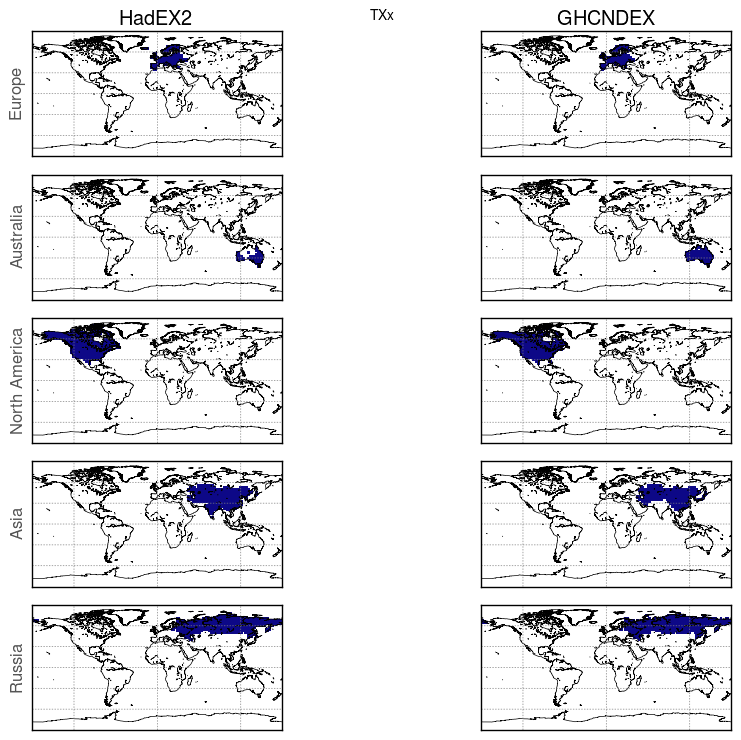

In [82]:
###########
# Plot Masks
###########
fig,pl=plt.subplots(nrows=5,ncols=2,figsize=(11,7.5))
pplot=pl.flatten()
k=0
for region in region_polygons.keys():
    for dataset in ['HadEX2','GHCNDEX']:
        mask=varoutdict[dataset]['TXx']._masks[region].copy()
        mask[np.isfinite(mask)]=1
        varoutdict[dataset][varin].plot_map(mask,
                                            ax=pplot[k],
                                            color_bar=False,
                                            show=False)
        if k<2:pplot[k].set_title(dataset)
        if (-1)**k>0:pplot[k].set_ylabel(region.replace('_',' '))
        k+=1
plt.suptitle('TXx')
plt.tight_layout()
plt.show()

In [72]:
##############
# Prepare Polygons
##############

os.chdir('/Users/peterpfleiderer/Documents/')


m = Basemap()
m.readshapefile("masks/shapefiles/world/ne_50m_admin_0_countries", 'admin', drawbounds=False)

region_polygons={}

# Europe
name='Europe'
region_polygons.pop(name, None)
for shape, region in zip(m.admin, m.admin_info):
    region = {k.lower():v for k,v in region.items()}    
    if region['continent'] in ['Europe'] and region['admin']!='Russia':
        #print region['admin']
        if name in region_polygons.keys():
            region_polygons[name] = \
            region_polygons[name].symmetric_difference(Polygon(shape))
        else:
            region_polygons[name] = Polygon(shape)

region_polygons['Europe']=region_polygons['Europe'].intersection(Polygon([[0,35],[50,35],[50,70],[0,70]])).symmetric_difference(region_polygons['Europe'].intersection(Polygon([[-30,35],[0,35],[0,70],[-30,70]])))

# North_America
name='North_America'
region_polygons.pop(name, None)
for shape, region in zip(m.admin, m.admin_info):
    region = {k.lower():v for k,v in region.items()}    
    if region['admin'] in ['United States of America', 'Canada']:
        if name in region_polygons.keys():
            region_polygons[name] = \
            region_polygons[name].symmetric_difference(Polygon(shape))
        else:
            region_polygons[name] = Polygon(shape)

# Russia
name='Russia'
region_polygons.pop(name, None)
for shape, region in zip(m.admin, m.admin_info):
    region = {k.lower():v for k,v in region.items()}    
    if region['admin'] in ['Russia']:
        if name in region_polygons.keys():
            region_polygons[name] = \
            region_polygons[name].symmetric_difference(Polygon(shape))
        else:
            region_polygons[name] = Polygon(shape)

# Australia
name='Australia'
region_polygons.pop(name, None)
for shape, region in zip(m.admin, m.admin_info):
    region = {k.lower():v for k,v in region.items()}    
    if region['admin'] in ['Australia']:
        if name in region_polygons.keys():
            region_polygons[name] = \
            region_polygons[name].symmetric_difference(Polygon(shape))
        else:
            region_polygons[name] = Polygon(shape)

# Asia
name='Asia'
region_polygons.pop(name, None)
for shape, region in zip(m.admin, m.admin_info):
    region = {k.lower():v for k,v in region.items()}    
    if region['subregion'] in ['Eastern Asia', 'Southern Asia', 'Central Asia'] and region['admin']!='Russia':
        #print region['admin']
        #print region
        if name in region_polygons.keys():
            try:
                region_polygons[name] = \
                region_polygons[name].symmetric_difference(Polygon(shape))
            except:
                print 'problem with',region['admin']
        else:
            region_polygons[name] = Polygon(shape)
            
#continent_polygons={}
#continent_polygons['Oceania']=Polygon([[110,-10],[180,-10],[180,-50],[110,-50]])
#continent_polygons['North_America']=Polygon([[-170,25],[-50,25],[-50,70],[-170,70]])
#continent_polygons['Europe']=Polygon([[0,35],[50,35],[50,70],[0,70]]).symmetric_difference(Polygon([[-30,35],[0,35],[0,70],[-30,70]]))


ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.8305 37.2859, 74.8754 37.242) and LINESTRING (74.8754 37.242, 74.8305 37.2859) at 74.87439236111112 37.242968750000003


problem with Tajikistan
